## Introduction:
You can use this ipython notebook as a template for the rest of the homework.

### 0. Basic Useful Setups:

In [1]:
### Basic setups
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import sys
sys.path.append('./models/')
# Enable automatic reload of libraries
%load_ext autoreload
# All modules are reloaded before every comment
%autoreload 2
import keras
import numpy as np
import time
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tqdm import tqdm

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

### 1. Read MNIST using Keras

In [3]:
from utils import load_mnist
(x_train, y_train), (x_test, y_test) = load_mnist()

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### 1. Load LetNet Model

In [4]:
from keras.utils.vis_utils import plot_model # can be used to plot the model into a png file.
from LeNet import LeNet
NUM_CLASSES = 10
model = LeNet(num_classes = NUM_CLASSES)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
# You can save the model by specifying a path
# modelPath = ____
# model.save(modelPath)

# You can also print out the model by typing
model.summary()

# You can plot the model into a png file and use it in your report.
pngModelPath = './png/LeNet.png'
plot_model(model, to_file=pngModelPath, show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 28, 28, 20)        520       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 20)        0         
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 50)        25050     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2450)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 500)               1225500   
__________

### 2. Train and Evaluate LeNet Model

In [5]:
# train model
BATCH_SIZE = 128
time_callback = TimeHistory()
MAX_EPOCH = 12

history_1 = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=MAX_EPOCH,
          verbose=1,
          validation_data=(x_test, y_test),callbacks=[time_callback])
score = model.evaluate(x_test, y_test, verbose=0)
times_1 = time_callback.times
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(times_1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 164s 3ms/step - loss: 0.1913 - acc: 0.9412 - val_loss: 0.0547 - val_acc: 0.9816
Epoch 2/12
60000/60000 [==============================] - 179s 3ms/step - loss: 0.0441 - acc: 0.9868 - val_loss: 0.0344 - val_acc: 0.9884
Epoch 3/12
60000/60000 [==============================] - 162s 3ms/step - loss: 0.0280 - acc: 0.9915 - val_loss: 0.0394 - val_acc: 0.9864
Epoch 4/12
60000/60000 [==============================] - 181s 3ms/step - loss: 0.0204 - acc: 0.9933 - val_loss: 0.0267 - val_acc: 0.9907
Epoch 5/12
60000/60000 [==============================] - 171s 3ms/step - loss: 0.0151 - acc: 0.9951 - val_loss: 0.0207 - val_acc: 0.9922
Epoch 6/12
60000/60000 [==============================] - 167s 3ms/step - loss: 0.0110 - acc: 0.9964 - val_loss: 0.0225 - val_acc: 0.9919
Epoch 7/12
60000/60000 [==============================] - 153s 3ms/step - loss: 0.0085 - acc: 0.9975 - val_loss: 0.0216 - 

# Rapid Net

In [6]:
from keras.utils.vis_utils import plot_model # can be used to plot the model into a png file.
from Rapid_Net import Rapid_Net

NUM_CLASSES = 10
MAX_EPOCH = 12
model = Rapid_Net((28,28,1),num_classes = NUM_CLASSES)

# You can also print out the model by typing
model.summary()

# You can plot the model into a png file and use it in your report.
pngModelPath = './png/Rapid_Net.png'
plot_model(model, to_file=pngModelPath, show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 32)          9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              295936    
__________

# Hyperparameter tune
## Optimizers
Stochastic Gradient Descent, Adaptive Gradient, RMSprop and/or Nesterov's Accelerated Gradient

In [7]:
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
score_log = []
BATCH_SIZE = 128
for opt in tqdm(optimizer):
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])
    model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=MAX_EPOCH,
          verbose=0)
    score = model.evaluate(x_test, y_test, verbose=0)
    score_log.append([opt,score])  

100%|██████████| 7/7 [22:42<00:00, 194.60s/it]


In [8]:
score_log

[['SGD', [0.1138008848387748, 0.9669]],
 ['RMSprop', [0.038905511912731575, 0.9901]],
 ['Adagrad', [0.037174660887556596, 0.9915]],
 ['Adadelta', [0.04517000092788248, 0.9917]],
 ['Adam', [0.046639757655718816, 0.9909]],
 ['Adamax', [0.051536800559021094, 0.9916]],
 ['Nadam', [0.0599945265445127, 0.9888]]]

In [9]:
score_log_lr = []
learning_rate = [0.0002,0.002,0.02,0.2]
for learn in tqdm(learning_rate):
    model = Rapid_Net((28,28,1),num_classes = NUM_CLASSES)
    opt = keras.optimizers.Adamax(lr=learn, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])
    model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=MAX_EPOCH,
          verbose=0)
    score = model.evaluate(x_test, y_test, verbose=0)
    score_log_lr.append([learn,score])  

100%|██████████| 4/4 [12:36<00:00, 189.17s/it]


In [10]:
score_log_lr

[[0.0002, [0.08346837266627699, 0.9739]],
 [0.002, [0.033176287287444574, 0.9895]],
 [0.02, [0.044044104952702126, 0.9895]],
 [0.2, [14.538521841430665, 0.098]]]

In [11]:
model = Rapid_Net((28,28,1),num_classes = NUM_CLASSES)
opt = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])
# train model
BATCH_SIZE = 128
time_callback = TimeHistory()

history_2 = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=36,
          verbose=1,
          validation_data=(x_test, y_test),callbacks=[time_callback])
score = model.evaluate(x_test, y_test, verbose=0)
times_2 = time_callback.times
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(times_2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/36
60000/60000 [==============================] - 21s 349us/step - loss: 0.3056 - acc: 0.9104 - val_loss: 0.1093 - val_acc: 0.9662
Epoch 2/36
60000/60000 [==============================] - 20s 330us/step - loss: 0.1014 - acc: 0.9689 - val_loss: 0.0721 - val_acc: 0.9779
Epoch 3/36
60000/60000 [==============================] - 20s 340us/step - loss: 0.0698 - acc: 0.9782 - val_loss: 0.0644 - val_acc: 0.9799
Epoch 4/36
60000/60000 [==============================] - 18s 307us/step - loss: 0.0560 - acc: 0.9826 - val_loss: 0.0471 - val_acc: 0.9847
Epoch 5/36
60000/60000 [==============================] - 18s 295us/step - loss: 0.0452 - acc: 0.9860 - val_loss: 0.0386 - val_acc: 0.9882
Epoch 6/36
60000/60000 [==============================] - 18s 305us/step - loss: 0.0374 - acc: 0.9880 - val_loss: 0.0372 - val_acc: 0.9878
Epoch 7/36
60000/60000 [==============================] - 20s 330us/step - loss: 0.0328 - acc: 0.9897 - val_loss: 0.

# Plot - Loss

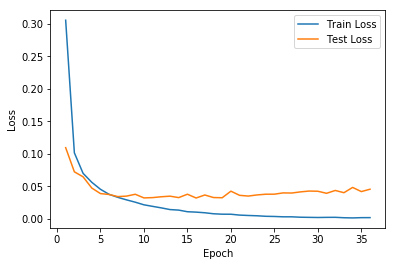

In [22]:
plt.plot(range(1,37), history_2.history['loss'], label='Train Loss')
plt.plot(range(1,37), history_2.history['val_loss'], label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Analysis

In [13]:
print('Time taken for running LeNet is', sum(times_1))
print('Time taken for running Rapid_Net is', sum(times_2))

Time taken for running LeNet is 1964.7795357704163
Time taken for running Rapid_Net is 714.9772017002106


# Comparison Plot

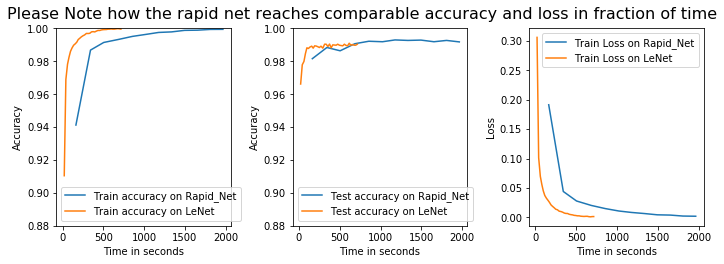

In [39]:
#Find cumulative sum
cum_times_1 = np.cumsum(times_1)
cum_times_2 = np.cumsum(times_2)

fig = plt.figure(figsize=(10,10))

#plt.subplot(4, 4, 1)
#plt.plot(range(1,13),history_1.history['acc'])
#plt.plot(range(1,37),history_2.history['acc'])
#plt.ylim([0.88,1])
fig.suptitle("Please Note how the rapid net reaches comparable accuracy and loss in fraction of time", fontsize=16)
#plt.title('Please Note how the rapid net reaches comparable accuracy and loss in fraction of time')
plt.subplot(3, 3, 1)
plt.plot(cum_times_1,history_1.history['acc'], label='Train accuracy on Rapid_Net')
plt.plot(cum_times_2,history_2.history['acc'], label='Train accuracy on LeNet')
plt.legend()
plt.xlabel('Time in seconds')
plt.ylabel('Accuracy')
plt.ylim([0.88,1])

plt.subplot(3, 3, 2)
plt.plot(cum_times_1,history_1.history['val_acc'], label='Test accuracy on Rapid_Net')
plt.plot(cum_times_2,history_2.history['val_acc'], label='Test accuracy on LeNet')
plt.legend()
plt.xlabel('Time in seconds')
plt.ylabel('Accuracy')
plt.ylim([0.88,1])

plt.subplot(3, 3, 3)
plt.plot(cum_times_1,history_1.history['loss'], label='Train Loss on Rapid_Net')
plt.plot(cum_times_2,history_2.history['loss'], label='Train Loss on LeNet')
plt.legend()
plt.xlabel('Time in seconds')
plt.ylabel('Loss')

fig.tight_layout()
fig.subplots_adjust(top=0.95)
#plt.ylim([0.88,1])

#plt.figure()
#plt.plot(cum_times_1,history_1.history['val_loss'])
#plt.plot(cum_times_2,history_2.history['val_loss'])
#plt.ylim([0,0.2])